<a href="https://colab.research.google.com/github/ImNotDanish05/2025_Visi-Komputer_TI-2A/blob/main/Jobsheet03_TEKNIK-REGRESI_-GAMBAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: ImNotDanish05

# **Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)**

Pernahkah Anda memperhatikan wajah seseorang dan mencoba menebak usianya?
Mungkin dari garis senyum, bentuk rahang, atau tekstur kulit. Nah, komputer juga bisa
melakukan hal yang sama — dengan belajar dari ribuan contoh wajah berlabel umur.
Di praktikum ini, kita akan membuat sistem sederhana yang mampu memperkirakan umur
seseorang dari fotonya menggunakan teknik regresi gambar.

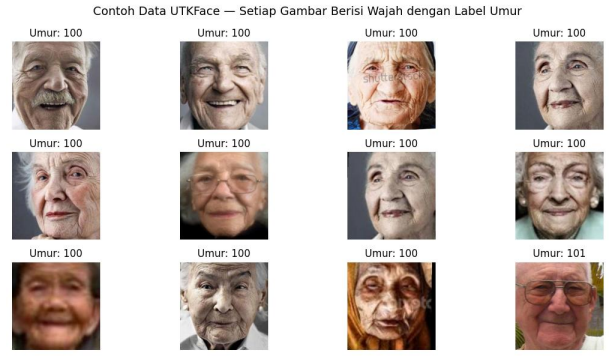

Dataset yang digunakan bernama UTKFace, berisi ribuan foto wajah manusia dari berbagai
usia, jenis kelamin, dan ras. Setiap foto memiliki nama file yang sudah menyimpan label umur